In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [30]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [45]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
dummy_length = pynbody.array.SimArray(1., "cm")
dummy_mass = pynbody.array.SimArray(1., "g")
turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb*1e5, units = "cm s**-1")
T = region.g["temp"]
c_s = np.sqrt(K_b * T_mean / m_p)
mach_no_sim = turb / c_s
region.g["mach"] = mach_no_sim.in_units("1")
m_p_1 = pynbody.array.SimArray(1.0, pynbody.units.m_p)
n_H_mean_sim = rho / m_p_1

In [11]:
# c_s = np.sqrt(region.gas["p"] / region.gas["rho"])
# c_s = c_s.in_units('cm s**-1')

In [33]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1/np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

In [34]:
def calc_integral(s, pdf, X_H2, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_H2[i]*ds)
    return integ

In [35]:
def calc_integral2(s, pdf, X_CO, ds):
    integ = 0.0
    for i in range(0, 100):
        integ += (np.exp(s[i])*pdf[i]*X_CO[i]*ds)
    return integ

In [36]:
def calc_lambda_jeans(n_H, c_s):
    lambda_jeans = (c_s / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

In [37]:
def calc_n_LW(n_H, G_o, lambda_jeans, Z):
    kappa = 1000 * m_p * (Z/0.02)
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

In [38]:
def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans):
    kappa = 1000 * m_p * (Z/0.02)
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2*lambda_jeans
    #N_H2 = N_H2.in_units('1')
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    #term1 = term1.in_units('1')
    #term2 = term2.in_units('1')
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss

In [39]:
def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1 / (2 + (numerator/denominator) )
    return X_H2

In [48]:
def self_shielding_iterations(n_H, G_o, lambda_jeans, Z):
    X_H2 = np.zeros(100)
    n_LW = np.zeros(100)
    n_H2 = np.zeros(100)
    n_LW_ss = np.zeros(100)
    S_H2_ss = np.zeros(100)
    N_H2_ss = np.zeros(100)
    X_H2_ss = np.zeros(100)
    n_H2_ss = np.zeros(100)
    ctr = 15
    i = 0
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, Z)
    X_H2 = calc_X_H2(n_H, Z, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    while i<ctr:
        #for j in range(100):
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, G_o, lambda_jeans)
        X_H2_ss = calc_X_H2(n_H, Z, n_LW_ss)
        n_H2_ss = n_H * X_H2_ss
        i += 1
    return n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2

In [41]:
def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16 #cm3 s-1
    k1 = 5.0e-10 #cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return X_CO

In [42]:
def calc_n_CO(n_H, X_CO, Z):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * (Z/0.02) * X_CO # CO/cc

In [43]:
def inside_loop(M, n_H_mean, Z, G_o, c_s):
    s = np.zeros(100)
    n_H = np.zeros(100)
    pdf = np.zeros(100)
    lambda_jeans = np.zeros(100)
    X_CO = np.zeros(100)
    n_CO = np.zeros(100)
    integral1 = 0
    integral2 = 0
    sigma_s = np.sqrt(np.log(1 + ((0.3 * M)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -7*sigma_s + s_bar
    smax = 7*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(100):
        s[i] = smin + i*ds
    pdf = make_pdf(s, s_bar, sigma_s)
    n_H = n_H_mean * np.exp(s)
    lambda_jeans = calc_lambda_jeans(n_H, c_s)
    n_LW, n_LW_ss, X_H2_ss, n_H2_ss, n_H2 = self_shielding_iterations(n_H, G_o, lambda_jeans, Z)
    integral1 = calc_integral(s, pdf, X_H2_ss, ds)
    X_H2_bar = 2*integral1
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, Z)
    integral2 = calc_integral2(s, pdf, X_CO, ds)
    X_CO_bar = integral2
    return X_H2_bar, X_CO_bar

In [51]:
%%time
Z = 1
G_o = 1
#mach_no_arr = mach_no_sim
#n_H_mean_arr = n_H_mean_sim
mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 2, 100), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-2, 3.5, 100), "cm**-3")
X_H2_bar = np.zeros(len(n_H_mean_arr))
X_CO_bar = np.zeros(len(n_H_mean_arr))
for m in range(len(mach_no_arr)):
    mach_no = mach_no_arr[m]
    n_H_mean = n_H_mean_arr[m]
    X_H2_bar[m], X_CO_bar[m] = inside_loop(mach_no, n_H_mean, Z, G_o, c_s)

CPU times: user 2.84 s, sys: 726 ms, total: 3.56 s
Wall time: 2.87 s


In [52]:
%%time
min_n_H = np.log10(np.min(n_H_mean_arr))
max_n_H = np.log10(np.max(n_H_mean_arr))
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
min_X = np.min(X_H2_bar)
max_X = np.max(X_H2_bar)
min_C = np.min(X_CO_bar)
max_C = np.max(X_CO_bar)

CPU times: user 617 µs, sys: 0 ns, total: 617 µs
Wall time: 497 µs


/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  
/home/cluster/mkrets/anaconda2/lib/python2.7/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


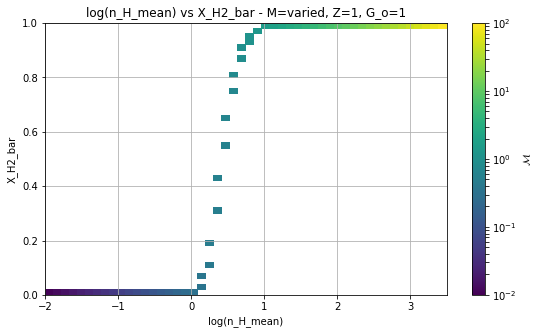

CPU times: user 567 ms, sys: 79.3 ms, total: 646 ms
Wall time: 577 ms


In [54]:
%%time
plt.figure(figsize=(9,5))
histX_H2_M_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=mach_no_arr, bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])
histX_H2_mass, yedges, xedges = np.histogram2d(X_H2_bar, np.log10(n_H_mean_arr),
                               weights=None, bins=50 , range=[[min_X,max_X],[min_n_H,max_n_H]])

yX_H2_M, xX_H2_M = yedges, xedges
plt.pcolormesh(xedges, yedges, histX_H2_M_mass/histX_H2_mass, norm=LogNorm(), vmin=min_M, vmax=max_M)
plt.colorbar(label=r"$\mathcal{M}$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=1, G_o=1')
plt.show()

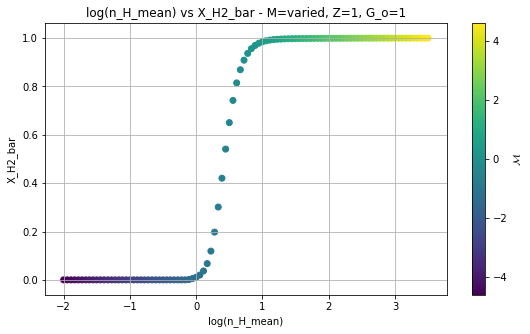

CPU times: user 270 ms, sys: 502 ms, total: 772 ms
Wall time: 768 ms


In [62]:
%%time
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_mean_arr), X_H2_bar, 
            c=np.log(mach_no_arr), vmin=np.log(min_M), vmax=np.log(max_M), cmap='viridis')
plt.colorbar(label=r"$\mathcal{M}$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_H2_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=1, G_o=1')
plt.show()

/net/cephfs/home/mkrets/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


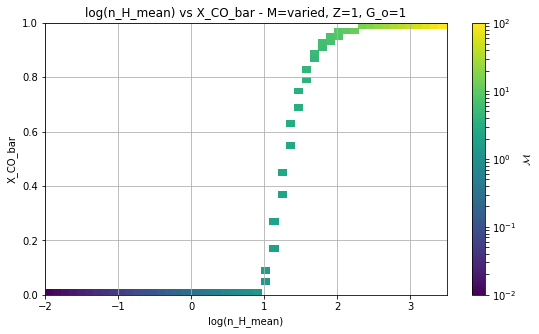

CPU times: user 376 ms, sys: 19.2 ms, total: 395 ms
Wall time: 382 ms


In [58]:
%%time
plt.figure(figsize=(9,5))
histX_CO_M_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=mach_no_arr, bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])
histX_CO_mass, y1edges, x1edges = np.histogram2d(X_CO_bar, np.log10(n_H_mean_arr),
                               weights=None, bins=50 , range=[[min_C,max_C],[min_n_H,max_n_H]])

yX_CO_M, xX_CO_M = y1edges, x1edges
plt.pcolormesh(x1edges, y1edges, histX_CO_M_mass/histX_CO_mass, norm=LogNorm(), vmin=min_M, vmax=max_M)
plt.colorbar(label=r"$\mathcal{M}$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=varied, Z=1, G_o=1')
plt.show()

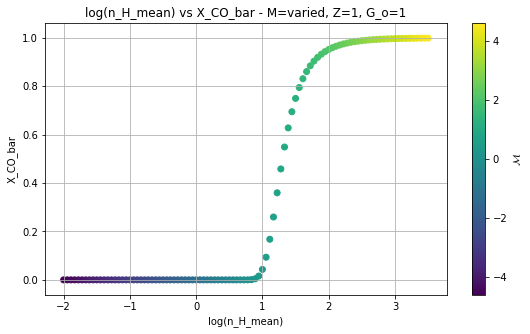

CPU times: user 199 ms, sys: 10.5 ms, total: 209 ms
Wall time: 206 ms


In [61]:
%%time
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_mean_arr), X_CO_bar, 
            c=np.log(mach_no_arr), vmin=np.log(min_M), vmax=np.log(max_M), cmap='viridis')
plt.colorbar(label=r"$\mathcal{M}$")
plt.xlabel('log(n_H_mean)')
plt.ylabel('X_CO_bar')
plt.grid(b=True, which='both', axis='both')
plt.title('log(n_H_mean) vs X_CO_bar - M=varied, Z=1, G_o=1')
plt.show()

In [63]:
# region.gas["X_H2_bar"] = X_H2_bar
# region.gas["n_H_mean_arr"] = n_H_mean_arr
# region.gas["X_CO_bar"] = X_CO_bar

# plt.figure(figsize=(9,5))
# pynbody.plot.image(region.g, qty="X_H2_bar", width='15.0 kpc',
#                    log=False, resolution=1000, cmap="viridis", av_z="n_H_mean_arr",
#                    vmin=5e-2, vmax=1)
# plt.title("X_H2_bar-n_H_mean(cm^-3)")
# plt.savefig('outputs/1.5/X_H2_bar-n_H_mean-1.5.png', dpi=300, bbox_inches='tight')
# plt.show()

# plt.figure(figsize=(9,5))
# pynbody.plot.image(region.g, qty="X_CO_bar", width='15.0 kpc',
#                    log=False, resolution=1000, cmap="viridis", av_z="n_H_mean_arr",
#                    vmin=5e-10, vmax=1.0)
# plt.title("X_CO_bar-n_H_mean(cm^-3)")
# plt.savefig('outputs/1.5/X_CO_bar-n_H_mean-1.5.png', dpi=300, bbox_inches='tight')
# plt.show()

In [64]:
# #Insert 3D plot

# %%time
# fig = plt.figure(figsize=(9,5))
# ax = fig.add_subplot(1, 2, 1, projection='3d')
# ax.plot_trisurf(X_H2_bar, np.log10(n_H_mean_sim), np.log(mach_no_sim), 
#                    norm=np.log(Z_arr), vmin=np.log(min_Z), vmax=np.log(max_Z), cmap='viridis')
# plt.colorbar(label="$Z$")
# plt.xlabel('log(n_H_mean)')
# plt.ylabel('X_H2_bar')
# plt.zlabel('Mach no.')
# plt.grid(b=True, which='both', axis='both')
# plt.title('log(n_H_mean) vs X_H2_bar - M=varied, Z=varied, G_o=1')